In [3]:
from dask.distributed import LocalCluster, Client
import dask.dataframe as dd
import time

cluster = LocalCluster(n_workers=4, dashboard_address=":8181")

client = Client(cluster)


non_zero_reviews = dd.read_parquet(
    "/home/ryba/Documents/Code/snek/bigdata/non_zero/", blocksize=40_000_000
)

client


/opt/anaconda/envs/dask-ml/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8181 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41163 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:41163/status,
Dashboard: http://127.0.0.1:41163/status,Workers: 4
Total threads: 16,Total memory: 15.24 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41929,Workers: 4
Dashboard: http://127.0.0.1:41163/status,Total threads: 16
Started: Just now,Total memory: 15.24 GiB
Comm: tcp://127.0.0.1:38007,Total threads: 4
Dashboard: http://127.0.0.1:43061/status,Memory: 3.81 GiB
Nanny: tcp://127.0.0.1:33911,


### Filtracja anglojęzycznych ocen i optymalizacja typów danych

zapis do pliku przetworzonego zbioru (nie będę przecież przetwarzać 110 milionów rekordów za każdym razem)


In [2]:
# df = dd.read_csv(
#     "/home/ryba/Documents/Code/snek/bigdata/all_reviews.csv",
#     encoding="ISO-8859-1",
#     usecols=[
#         "appid", #id of a game
#         "author_num_games_owned", # number of owned games
#         "author_num_reviews", # number of reviews made by the user
#         "author_playtime_forever", # playtime
#         "author_playtime_at_review", # playtime at the moment of review
#         "language", # language of the review
#         "review", # review text
#         "voted_up", # boolean if the review was positive
#         "votes_up", # number of upvotes
#         "votes_funny", # number of funny votes
#         "weighted_vote_score", # score of the review
#         "comment_count", # number of comments
#         "steam_purchase", # boolean if the game was bought on steam
#         "received_for_free", # boolean if the game was received for free
#         "written_during_early_access", # boolean if the review was written during early access
#     ],
#     dtype={'weighted_vote_score': 'float32'},
#     assume_missing=True,
#     blocksize=50_000_000 # 50 MB chunks
# )

# df = df.dropna(subset=['author_num_games_owned', 'author_num_reviews',
#                       'author_playtime_forever', 'author_playtime_at_review',
#                       'votes_up', 'votes_funny', 'comment_count'])

# df['appid'] = df['appid'].astype('uint32')
# df['author_num_games_owned'] = df['author_num_games_owned'].astype('uint16')
# df['author_num_reviews'] = df['author_num_reviews'].astype('uint16')
# df['author_playtime_forever'] = df['author_playtime_forever'].astype('uint32')
# df['author_playtime_at_review'] = df['author_playtime_at_review'].astype('uint32')
# df['voted_up'] = df['voted_up'].astype('uint8')
# df['votes_up'] = df['votes_up'].astype('uint16')
# df['votes_funny'] = df['votes_funny'].astype('uint32')
# df['comment_count'] = df['comment_count'].astype('uint32')
# df['steam_purchase'] = df['steam_purchase'].astype('uint8')
# df['received_for_free'] = df['received_for_free'].astype('uint8')
# df['written_during_early_access'] = df['written_during_early_access'].astype('uint8')

# en_reviews = df[df["language"] == "english"]
# en_reviews = en_reviews.drop(columns=["language"])
# en_reviews.to_parquet('/home/ryba/Documents/Code/snek/bigdata/en_reviews/', compression='snappy')
# df["language"].value_counts().compute()


Badanie zbioru po wyizolowaniu 51 milionów anglojęzycznych recenzji


In [3]:
en_reviews = dd.read_parquet(
    "/home/ryba/Documents/Code/snek/bigdata/en_reviews/", blocksize=40_000_000
)
en_reviews.dtypes


appid                                   uint32
author_num_games_owned                  uint16
author_num_reviews                      uint16
author_playtime_forever                 uint32
author_playtime_at_review               uint32
review                         string[pyarrow]
voted_up                                 uint8
votes_up                                uint16
votes_funny                             uint32
weighted_vote_score                    float32
comment_count                           uint32
steam_purchase                           uint8
received_for_free                        uint8
written_during_early_access              uint8
dtype: object

In [4]:
en_reviews.head()


,appid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_at_review,review,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access
4,10,0,2,197,197,GOAT Game !!,1,0,0,0.00000,0,1,0,0
10,10,69,1,12107,12107,First crush. Always in my heart.,1,0,0,0.00000,0,0,0,0
11,10,0,5,42519,42515,"best version of cs ever, history.",1,0,0,0.00000,0,0,0,0
25,10,71,34,30,30,"a game everyone needs, but not to play.",1,0,0,0.00000,0,1,0,0
28,10,5,6,209,209,old but gold,1,1,0,0.52381,0,1,0,0


In [5]:
en_reviews.describe().compute()


,appid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_at_review,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access
count,51544610,51544610,51544610,51544610,51544610,51544610,51544610,51544610,5.154461e+07,51544610,51544610,51544610,51544610
mean,617253.467581,145.756434,30.520632,14670.158607,6937.305495,0.86004,2.489981,72077.090477,1.898799e-01,83.44959,0.664512,0.036373,0.117023
std,529393.840208,522.35018,216.622118,47460.000675,26022.91935,0.346946,39.841118,17594326.456462,2.513839e-01,598230.060511,0.472161,0.187216,0.321447
min,10,0,1,0,0,0,0,0,0.000000e+00,0,0,0,0
25%,271590.0,0.0,4.0,1102.0,486.0,1.0,0.0,0.0,0.000000e+00,0.0,1.0,0.0,0.0
50%,501300.0,17.0,10.0,4211.0,1671.0,1.0,0.0,0.0,0.000000e+00,0.0,1.0,0.0,0.0
75%,1086940.0,268.0,40.0,111491.0,51383.75,1.0,3.0,1.0,5.238096e-01,0.0,1.0,0.0,1.0
max,2660040,30468,10446,6007985,4880175,1,62199,4294967295,9.955471e-01,4294967295,1,1,1


In [6]:
en_reviews.count().compute()


appid                          51544610
author_num_games_owned         51544610
author_num_reviews             51544610
author_playtime_forever        51544610
author_playtime_at_review      51544610
review                         51543422
voted_up                       51544610
votes_up                       51544610
votes_funny                    51544610
weighted_vote_score            51544610
comment_count                  51544610
steam_purchase                 51544610
received_for_free              51544610
written_during_early_access    51544610
dtype: int64

In [7]:
en_reviews.dtypes


appid                                   uint32
author_num_games_owned                  uint16
author_num_reviews                      uint16
author_playtime_forever                 uint32
author_playtime_at_review               uint32
review                         string[pyarrow]
voted_up                                 uint8
votes_up                                uint16
votes_funny                             uint32
weighted_vote_score                    float32
comment_count                           uint32
steam_purchase                           uint8
received_for_free                        uint8
written_during_early_access              uint8
dtype: object

In [8]:
en_reviews.min().compute()


appid                                                                         10
author_num_games_owned                                                         0
author_num_reviews                                                             1
author_playtime_forever                                                        0
author_playtime_at_review                                                      0
review                         .?m?xÃâ¢âÃoAÃÃ­Ã @XZÃ¨
LÂ¸8 â¦;...
voted_up                                                                       0
votes_up                                                                       0
votes_funny                                                                    0
weighted_vote_score                                                          0.0
comment_count                                                                  0
steam_purchase                                                                 0
received_for_free           

In [9]:
en_reviews.max().compute()


appid                                                                    2660040
author_num_games_owned                                                     30468
author_num_reviews                                                         10446
author_playtime_forever                                                  6007985
author_playtime_at_review                                                4880175
review                         ó °ó °ó °ó °ó °ó °ó °ó °ó °ó °ó °ó ...
voted_up                                                                       1
votes_up                                                                   62199
votes_funny                                                           4294967295
weighted_vote_score                                                     0.995547
comment_count                                                         4294967295
steam_purchase                                                                 1
received_for_free           

In [10]:
en_reviews["appid"].value_counts().compute()


2025-01-28 20:59:55,427 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 7bd9e29d6c33c7bea434ce41233fa408 initialized by task ('shuffle-transfer-7bd9e29d6c33c7bea434ce41233fa408', 46) executed on worker tcp://127.0.0.1:33905
2025-01-28 20:59:58,332 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 7bd9e29d6c33c7bea434ce41233fa408 deactivated due to stimulus 'task-finished-1738094398.3300102'
Task exception was never retrieved
future: <Task finished name='Task-703936' coro=<Client._gather.<locals>.wait() done, defined at /opt/anaconda/envs/dask-ml/lib/python3.12/site-packages/distributed/client.py:2395> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/anaconda/envs/dask-ml/lib/python3.12/site-packages/distributed/client.py", line 2404, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-762176' coro=<Client._gather.<locals>.wait() done, defined at /opt/anaconda/envs/dask-ml/l

appid
360          1768
440        599949
4900          212
8970           49
10607          69
            ...  
2583640         1
2589820         3
2615100         1
2616080         2
2621860         1
Name: count, Length: 97113, dtype: int64

Szukanie tylko wśród niezerowo ocenionych recenzji ok 10-20 milionów


In [ ]:
# non_zero_scores = en_reviews[en_reviews['weighted_vote_score'] != 0].count().compute()
# print(f"Number of reviews with non-zero weighted vote score: {non_zero_scores['weighted_vote_score']}")


NameError: name 'en_reviews' is not defined

Zapis do plików po przetworzeniu


In [3]:
# non_zero_reviews = en_reviews[en_reviews['weighted_vote_score'] != 0]
# non_zero_reviews.to_parquet('/home/ryba/Documents/Code/snek/bigdata/non_zero/', compression='snappy')


appid                                   uint32
author_num_games_owned                  uint16
author_num_reviews                      uint16
author_playtime_forever                 uint32
author_playtime_at_review               uint32
review                         string[pyarrow]
voted_up                                 uint8
votes_up                                uint16
votes_funny                             uint32
weighted_vote_score                    float32
comment_count                           uint32
steam_purchase                           uint8
received_for_free                        uint8
written_during_early_access              uint8
dtype: object

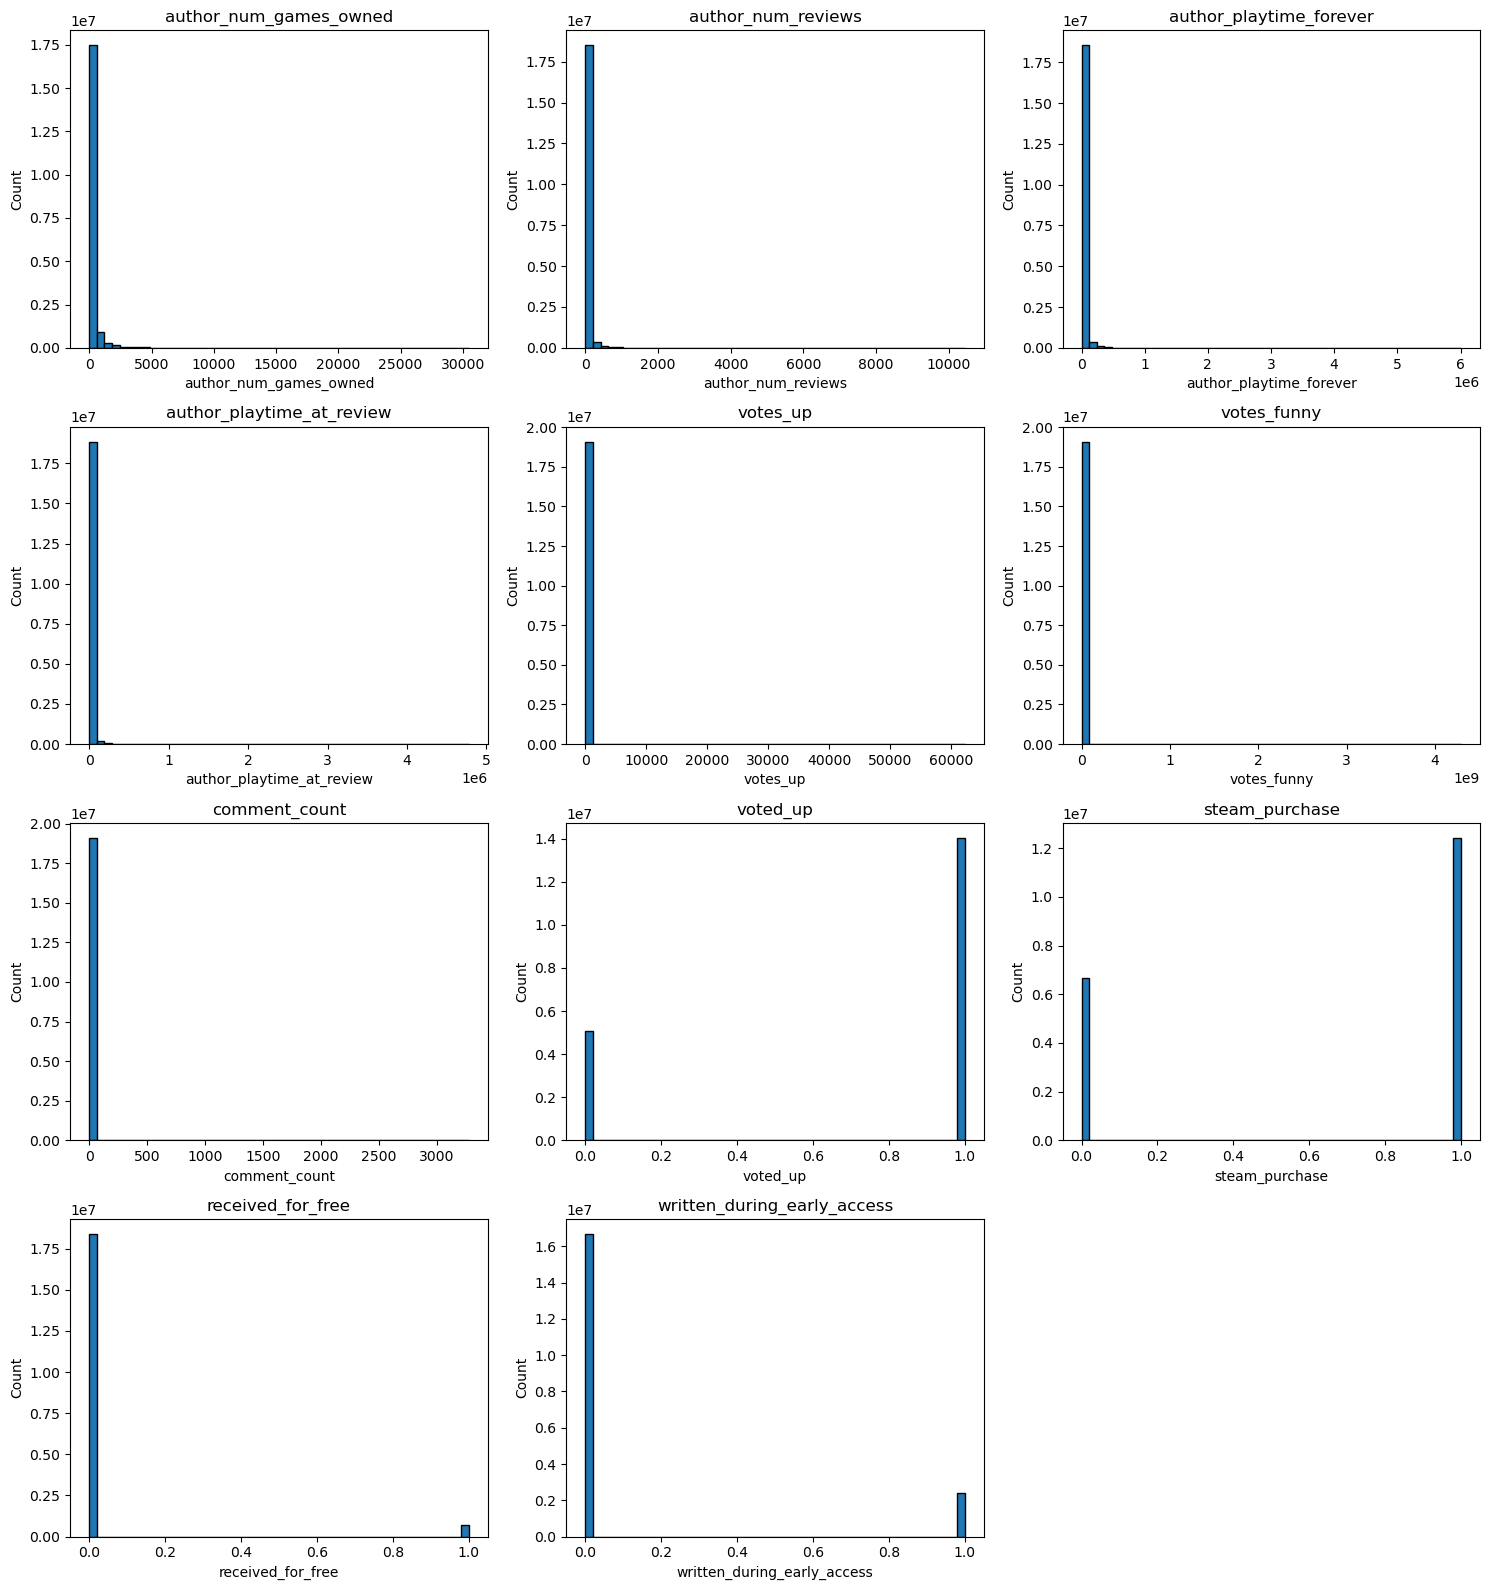

In [4]:
import numpy as np

import matplotlib.pyplot as plt

numerical_cols = [
    "author_num_games_owned",
    "author_num_reviews",
    "author_playtime_forever",
    "author_playtime_at_review",
    "votes_up",
    "votes_funny",
    "comment_count",
    "voted_up",
    "steam_purchase",
    "received_for_free",
    "written_during_early_access",
]

n_cols = 3
n_rows = int(np.ceil(len(numerical_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()
for idx, col in enumerate(numerical_cols):
    hist_data = non_zero_reviews[col].compute()
    axes[idx].hist(hist_data, bins=50, edgecolor="black")
    axes[idx].set_title(col)
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel("Count")

for idx in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


Checkpoint z macierzą korelacji


In [15]:
import pickle


# all_cols = numerical_cols + ['weighted_vote_score']
# correlation_df = non_zero_reviews[all_cols].copy()


# corr_matrix = correlation_df.corr().compute()

# with open('correlation_matrix.pkl', 'wb') as f:
#     pickle.dump(corr_matrix, f)

with open("correlation_matrix.pkl", "rb") as f:
    corr_matrix = pickle.load(f)

correlations = corr_matrix["weighted_vote_score"]
print("Correlations with weighted_vote_score:")
print(correlations.sort_values(ascending=False))


Correlations with weighted_vote_score:
weighted_vote_score            1.000000
votes_up                       0.277453
voted_up                       0.192354
comment_count                  0.107419
author_playtime_at_review      0.042457
author_playtime_forever        0.040794
author_num_games_owned         0.031171
steam_purchase                 0.019945
votes_funny                   -0.001145
received_for_free             -0.004560
written_during_early_access   -0.013413
author_num_reviews            -0.132158
Name: weighted_vote_score, dtype: float64


Macierz korelacji


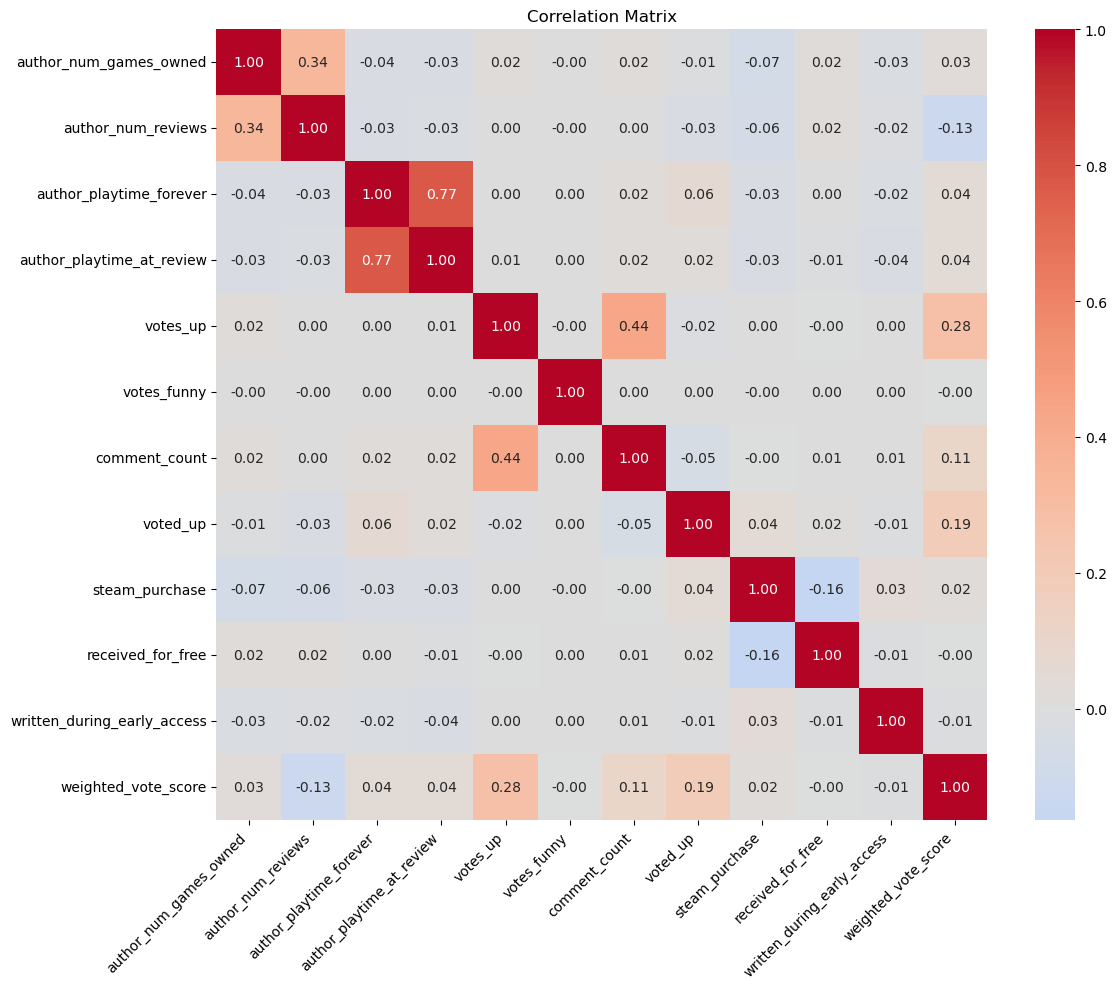

In [16]:
import seaborn as sns

import matplotlib.pyplot as plt

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Correlation Matrix")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()


Korelacje z weighed_vote_score


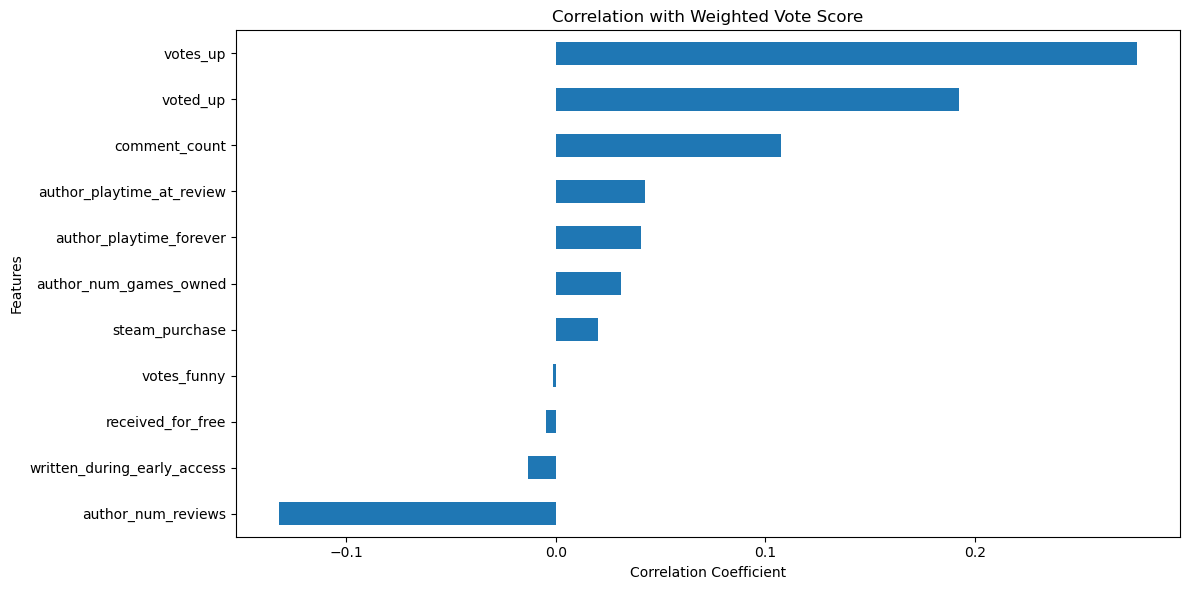

In [17]:
plt.figure(figsize=(12, 6))
correlations_sorted = correlations.sort_values(ascending=True)[:-1]
correlations_sorted.plot(kind="barh")

plt.title("Correlation with Weighted Vote Score")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Features")
plt.tight_layout()


### Model przewidujący weighted_vote_score

Użyłem kerasa i napisałem jakiś model attention based na podstawie tutoriala i tyle że ustawiłem to tak żeby dask działał

StandardScaler tylko jeśli chodzi o preprocessing. Nie musiałem używać onehota bo nie było kategorycznych
Typy Boolean wywalały się na niektórych frameworkach dlatego te zmienne reprezentowałem np.uint8 z czego dobrze pamiętam 

In [7]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Multiply
from dask_ml.wrappers import ParallelPostFit
from sklearn.base import BaseEstimator, RegressorMixin
import pandas as pd

X = non_zero_reviews[numerical_cols].compute()
y = non_zero_reviews["weighted_vote_score"].compute()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

class AttentionModel:
    def __init__(self):
        self.model = None

    def build_model(self, input_dim):
        inputs = Input(shape=(input_dim,))
        x = Dense(64, activation="relu")(inputs)
        x = Dense(32, activation="relu")(x)
        attention = Dense(32, activation="tanh")(x)
        attention = Dense(1, activation="sigmoid")(attention)
        weighted = Multiply()([x, attention])
        outputs = Dense(1)(weighted)

        self.model = Model(inputs=inputs, outputs=outputs)
        self.model.compile(optimizer="adam", loss="mse")

    def fit(self, X, y, **kwargs):
        if self.model is None:
            self.build_model(X.shape[1])
        self.model.fit(X, y, **kwargs)
        return self

    def predict(self, X):
        return self.model.predict(X)


In [19]:


attention_model = AttentionModel()
parallel_model = ParallelPostFit(attention_model)


X_train = X_train
y_train = y_train

parallel_model.fit(X_train, y_train)

predictions = parallel_model.predict(X_test)

from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")


477288/477288 ━━━━━━━━━━━━━━━━━━━━ 438s 915us/step - loss: 0.0024
119322/119322 ━━━━━━━━━━━━━━━━━━━━ 57s 475us/step
Mean Squared Error: 0.0019873047713190317


Podglądanie czy to w ogóle ma ręce i nogi


In [20]:
import numpy as np

# Generate 30 random indices
random_indices = np.random.choice(len(predictions), 20, replace=False)

# Print random pairs of predictions and actual values
for idx in random_indices:
    print(f"Prediction: {predictions[idx][0]:.6f}, Actual: {y_test.iloc[idx]:.6f}")


Prediction: 0.518125, Actual: 0.480540
Prediction: 0.493306, Actual: 0.502595
Prediction: 0.511675, Actual: 0.523810
Prediction: 0.539522, Actual: 0.515625
Prediction: 0.474287, Actual: 0.481250
Prediction: 0.529635, Actual: 0.538710
Prediction: 0.514249, Actual: 0.502488
Prediction: 0.584286, Actual: 0.638070
Prediction: 0.525379, Actual: 0.490260
Prediction: 0.506022, Actual: 0.523810
Prediction: 0.524467, Actual: 0.494727
Prediction: 0.448945, Actual: 0.457516
Prediction: 0.548835, Actual: 0.585466
Prediction: 0.502353, Actual: 0.472505
Prediction: 0.496737, Actual: 0.474138
Prediction: 0.516081, Actual: 0.523810
Prediction: 0.498817, Actual: 0.553847
Prediction: 0.479236, Actual: 0.467626
Prediction: 0.506801, Actual: 0.491681
Prediction: 0.511383, Actual: 0.444444


Zapisywanie modelu


In [21]:
import pickle

# with open("parallel_model.pkl", "wb") as f:
#     pickle.dump(parallel_model, f)


Kombinowałem żeby zrobić fajnego plota

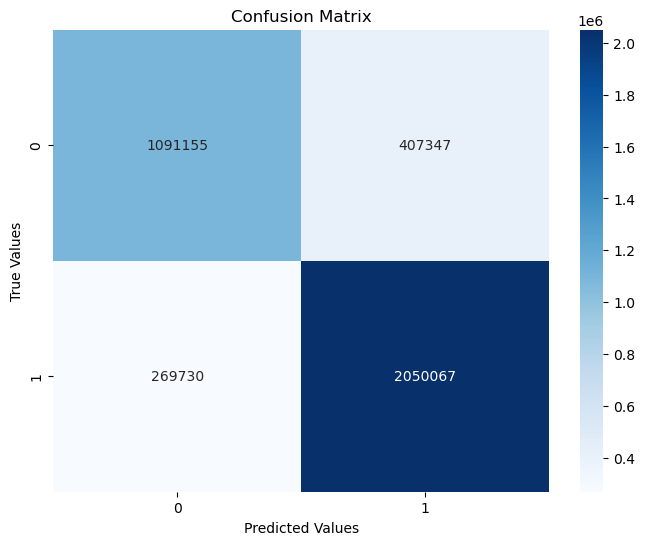


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.73      0.76   1498502
           1       0.83      0.88      0.86   2319797

    accuracy                           0.82   3818299
   macro avg       0.82      0.81      0.81   3818299
weighted avg       0.82      0.82      0.82   3818299



In [22]:
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import classification_report

threshold = 0.5
y_test_binary = (y_test > threshold).astype(int)
predictions_binary = (predictions > threshold).astype(int)

conf_matrix = confusion_matrix(y_test_binary, predictions_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("True Values")
plt.xlabel("Predicted Values")
plt.show()

print(classification_report(y_test_binary, predictions_binary))


Mało czytelne ROC przez ilość danych


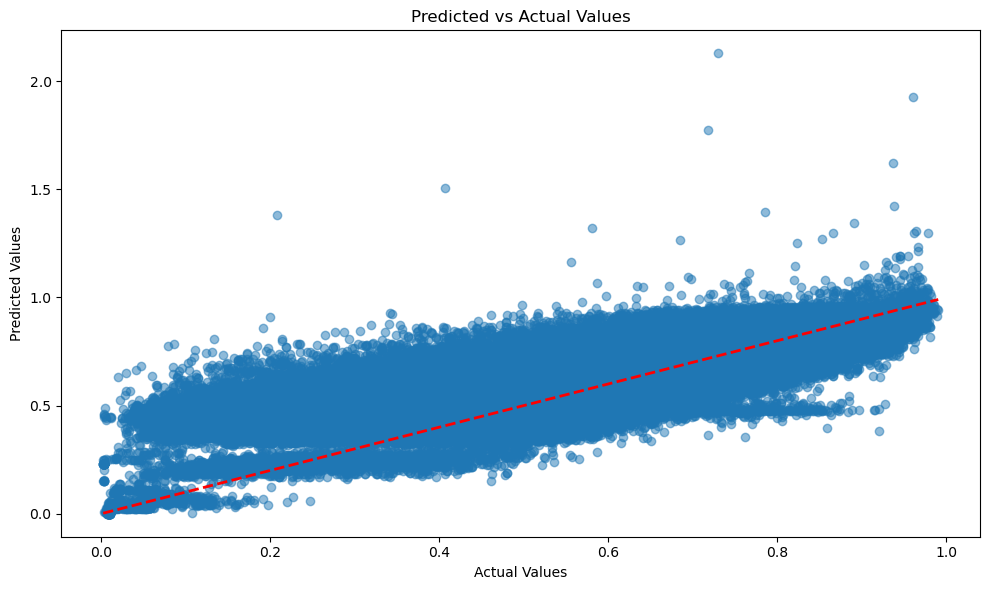

In [23]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.tight_layout()
plt.show()


In [49]:
non_zero_reviews.columns


Index(['appid', 'author_num_games_owned', 'author_num_reviews',
       'author_playtime_forever', 'author_playtime_at_review', 'review',
       'voted_up', 'votes_up', 'votes_funny', 'weighted_vote_score',
       'comment_count', 'steam_purchase', 'received_for_free',
       'written_during_early_access'],
      dtype='object')

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1s 401us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1s 391us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1s 445us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 511us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 510us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 487us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 514us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 501us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1s 467us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 484us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1s 467us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 476us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1s 428us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 498us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 548us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 480us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 495us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 483us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1s 474us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 506us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1s 460us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 480us/step
3125/3125 

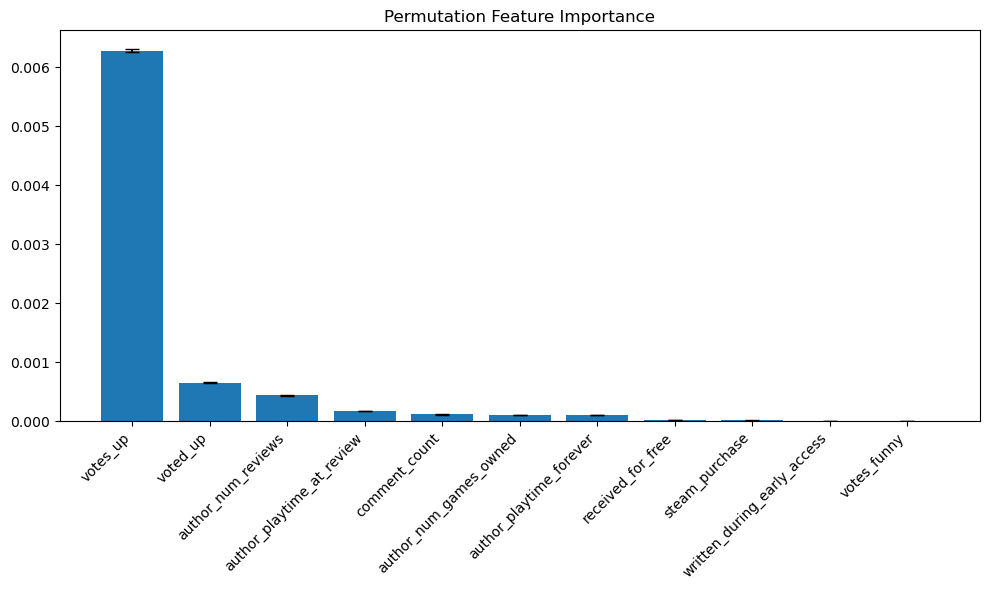


Permutation Feature Importance:
                        Feature  Permutation_Importance  Importance_Std
4                      votes_up            6.279973e-03    2.873507e-05
7                      voted_up            6.519352e-04    5.955321e-06
1            author_num_reviews            4.367025e-04    7.466813e-06
3     author_playtime_at_review            1.701862e-04    4.312750e-06
6                 comment_count            1.148856e-04    2.916582e-06
0        author_num_games_owned            1.083270e-04    4.220786e-06
2       author_playtime_forever            1.006709e-04    6.523260e-07
9             received_for_free            1.770346e-05    3.920228e-06
8                steam_purchase            1.165979e-05    1.878623e-06
10  written_during_early_access            7.672701e-06    1.564766e-06
5                   votes_funny            6.291084e-08    2.971257e-08


In [19]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
import numpy as np

with open("parallel_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)


def custom_score(estimator, X, y):
    predictions = estimator.predict(X)
    return -mean_squared_error(y, predictions)

result = permutation_importance(loaded_model, X_test[:100000], y_test[:100000], 
                              scoring=custom_score,
                              n_repeats=5, 
                              random_state=42)


perm_importance_df = pd.DataFrame({
    'Feature': numerical_cols,
    'Permutation_Importance': result.importances_mean,
    'Importance_Std': result.importances_std
})

perm_importance_df = perm_importance_df.sort_values('Permutation_Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(perm_importance_df['Feature'], perm_importance_df['Permutation_Importance'])
plt.errorbar(x=range(len(perm_importance_df)), 
            y=perm_importance_df['Permutation_Importance'],
            yerr=perm_importance_df['Importance_Std'],
            fmt='none', color='black', capsize=5)
plt.xticks(rotation=45, ha='right')
plt.title('Permutation Feature Importance')
plt.tight_layout()
plt.show()

print("\nPermutation Feature Importance:")
print(perm_importance_df)


Ogólnie to ciężko mi nawet określić co było bottleneckiem przy tych obliczeniach bo tensorflow używał GNA w moim procku i mało pokazywał

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step


<Figure size 1000x600 with 0 Axes>

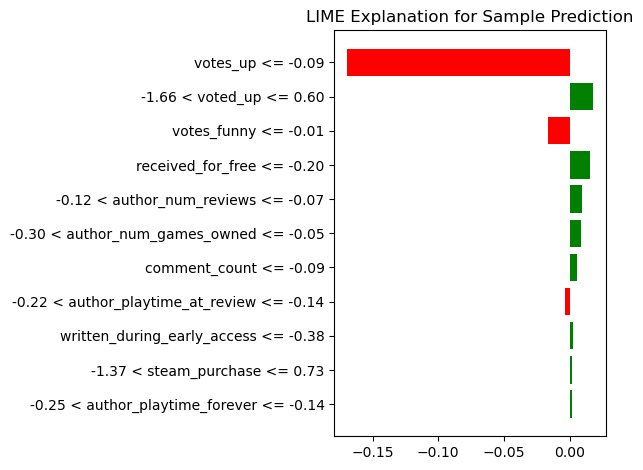

In [24]:
import lime

import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train,
    feature_names=numerical_cols,
    class_names=['weighted_vote_score'],
    mode='regression'
)

instance_idx = np.random.randint(0, len(X_test))
instance = X_test[instance_idx]

exp = explainer.explain_instance(
    instance, 
    lambda x: loaded_model.predict(x), 
    num_features=len(numerical_cols)
)

plt.figure(figsize=(10, 6))
exp.as_pyplot_figure()
plt.title('LIME Explanation for Sample Prediction')
plt.tight_layout()
plt.show()


In [26]:

print("Input features:")
for i, (col, val) in enumerate(zip(numerical_cols, instance)):
	print(f"{col}: {val:.4f}")

instance_reshaped = instance.reshape(1, -1)
prediction = loaded_model.predict(instance_reshaped)
print("\nPredicted weighted_vote_score:", prediction[0][0])
print("\nReal weighted_vote_score:", y_test.iloc[instance_idx])


Input features:
author_num_games_owned: -0.2076
author_num_reviews: -0.1073
author_playtime_forever: -0.1431
author_playtime_at_review: -0.1756
votes_up: -0.0857
votes_funny: -0.0067
comment_count: -0.0937
voted_up: 0.6007
steam_purchase: 0.7325
received_for_free: -0.1960
written_during_early_access: -0.3815
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step

Predicted weighted_vote_score: 0.5137337

Real weighted_vote_score: 0.44883075


Tutaj udało mi się odpalić sklearn to też zostawiłem

In [ ]:
import dask.dataframe as dd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

df = non_zero_reviews[
    [
        "votes_up",
        "comment_count",
        "voted_up",
        "author_num_reviews",
        "weighted_vote_score",
    ]
].compute()

X = df[["votes_up", "comment_count", "voted_up", "author_num_reviews"]]
y = df["weighted_vote_score"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SGD Classifier": SGDClassifier(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Linear SVC": LinearSVC(max_iter=1000, random_state=42),
}

for name, model in models.items():
    print(f"\nEvaluating {name}:")
    model.fit(X_train, y_train > 0.5)
    y_pred = model.predict(X_test)
    accuracy = (y_pred == (y_test > 0.5)).mean()
    mse = mean_squared_error(y_test > 0.5, y_pred)
    r2 = r2_score(y_test > 0.5, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R² Score: {r2:.4f}")



Evaluating Logistic Regression:
Accuracy: 0.6809
Mean Squared Error: 0.3191
R² Score: -0.3384

Evaluating SGD Classifier:
Accuracy: 0.6790
Mean Squared Error: 0.3210
R² Score: -0.3464

Evaluating Random Forest:
Accuracy: 0.8231
Mean Squared Error: 0.1769
R² Score: 0.2580

Evaluating Linear SVC:
Accuracy: 0.6722
Mean Squared Error: 0.3278
R² Score: -0.3750


### Stwierdziłem że to trochę mało więc dodałem drugi model analizy sentymentu

błąd bo mało RAMu mam żeby to działało a ten konkretny algorytm ma wymagania co do ilości npartition raz zwolniłem co mogłem odpaliłem system bez środowiska graficznego i udało się to policzyć więc mam model


In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from dask_ml.wrappers import ParallelPostFit
from dask_ml.model_selection import train_test_split as dask_train_test_split
from dask.distributed import Client
from sklearn.linear_model import SGDClassifier
import pickle

df = non_zero_reviews[["review", "voted_up"]].repartition(npartitions=120).compute()
df = df.dropna(subset=["review", "voted_up"]).reset_index(drop=True)

vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X = vectorizer.fit_transform(df["review"])

y = df["voted_up"]


X_train, X_test, y_train, y_test = dask_train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)


model = ParallelPostFit(
    SGDClassifier(loss="log_loss", penalty="l2", max_iter=1000, random_state=42)
)

model.fit(X_train, y_train)

predictions = model.predict(X_test)
accuracy = (predictions == y_test).mean()

print(f"Model accuracy: {accuracy}")

test_reviews = [
    "This game is amazing, I love everything about it!",
    "Terrible game, waste of money, don't buy it",
    "It's okay, not great but not bad either",
]

test_vectors = vectorizer.transform(test_reviews)

test_predictions = model.predict(test_vectors)
test_probabilities = model.predict_proba(test_vectors)

for review, pred, prob in zip(test_reviews, test_predictions, test_probabilities):
    print(f"\nReview: {review}")
    print(f"Prediction: {'Positive' if pred == 1 else 'Negative'}")
    print(f"Confidence: {max(prob):.2f}")

    with open("text_model.pkl", "wb") as f:
        pickle.dump({"model": model, "vectorizer": vectorizer}, f)


KeyboardInterrupt: 

In [13]:
# del model, vectorizer, X, y, X_train, X_test, y_train, y_test, predictions, accuracy, test_vectors, test_predictions, test_probabilities, test_reviews, df, non_zero_reviews, en_reviews

with open("text_model.pkl", "rb") as f:
    loaded_data = pickle.load(f)

model = loaded_data["model"]
vectorizer = loaded_data["vectorizer"]

test_reviews = [
    "This game is amazing, I love everything about it!",
    "Terrible game, waste of money, don't buy it",
    "It's okay, not great but not bad either",
]

test_vectors = vectorizer.transform(test_reviews)

test_predictions = model.predict(test_vectors)
test_probabilities = model.predict_proba(test_vectors)

for review, pred, prob in zip(test_reviews, test_predictions, test_probabilities):
    print(f"\nReview: {review}")
    print(f"Prediction: {'Positive' if pred == 1 else 'Negative'}")
    print(f"Confidence: {max(prob):.2f}")

    with open("text_model.pkl", "wb") as f:
        pickle.dump({"model": model, "vectorizer": vectorizer}, f)



Review: This game is amazing, I love everything about it!
Prediction: Positive
Confidence: 0.99

Review: Terrible game, waste of money, don't buy it
Prediction: Negative
Confidence: 0.98

Review: It's okay, not great but not bad either
Prediction: Positive
Confidence: 0.84


Lokalne wyjaśnienia przy big data mają dużą przewagę - nie potrzebują zbioru, wystarczy instancja

<Figure size 1000x600 with 0 Axes>

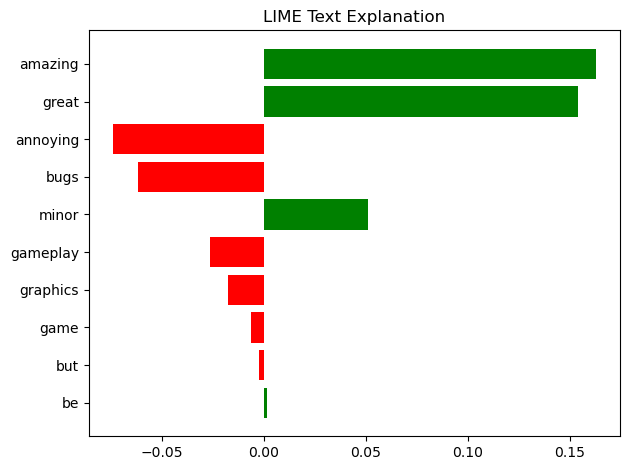

In [7]:
import lime
import numpy as np
import pickle
import matplotlib.pyplot as plt
import lime.lime_text

with open("text_model.pkl", "rb") as f:
    loaded_data = pickle.load(f)

model = loaded_data["model"]
vectorizer = loaded_data["vectorizer"]

text_explainer = lime.lime_text.LimeTextExplainer(class_names=['Negative', 'Positive'])

def predict_proba(texts):
    vectors = vectorizer.transform(texts)
    return model.predict_proba(vectors)

text_to_explain = "This game is amazing, great graphics and gameplay, but has some minor bugs that can be annoying"

explanation = text_explainer.explain_instance(
    text_to_explain, 
    predict_proba,
    num_features=10
)



plt.figure(figsize=(10, 6))
explanation.as_pyplot_figure()
plt.title('LIME Text Explanation')
plt.tight_layout()
plt.show()
